# Approach 1 - Simple Neural Style Transfer

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import IPython.display
import numpy as np
from tensorflow import keras

In [2]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0)
    return im_array

In [3]:
content_path='D:\CODE\Dashtoon\content_image.jpg'
style_path = 'D:\CODE\Dashtoon\Eu0S1S1VcAQMGDQ.jpeg'

In [4]:
content = load_file(content_path)
style = load_file(style_path)

C:\Users\beserkarray\AppData\Local\Temp\ipykernel_28916\3057713004.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


In [5]:
def show_im(img, title=None):
    img = np.squeeze(img, axis=0)
    plt.imshow(np.uint8(img))
    if title is not None:
        plt.title(title)
    plt.show()


C:\Users\beserkarray\AppData\Local\Temp\ipykernel_28916\3057713004.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


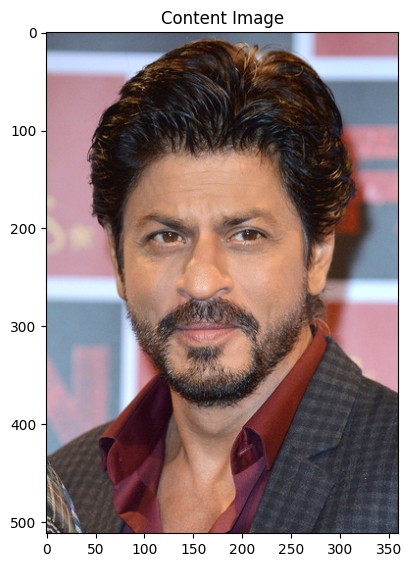

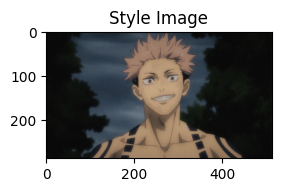

In [6]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

In [7]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

In [8]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]
  
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [9]:
im=img_preprocess(content_path)
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

C:\Users\beserkarray\AppData\Local\Temp\ipykernel_28916\3057713004.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


In [10]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature

In [11]:
def get_model():
    
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

In [12]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature

def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [13]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss= compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

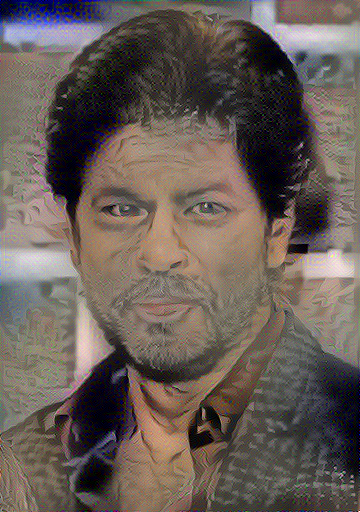

Epoch: 495
Total loss: 1.5456e+06, style loss: 8.5984e+05, content loss: 6.8577e+05, 


In [14]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=500)

# Appraoch 2 - CycleGAN (couldnt complete because i dont have the infrastructutre that could train a GAN)

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.12.0


c:\Users\beserkarray\anaconda3\envs\shreya\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [16]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result


def build_generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4), 
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)    

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,  kernel_initializer=initializer)(zero_pad2)


# Create generators and discriminators for both domains
generator_A = build_generator()
generator_B = build_generator()
discriminator_A = build_discriminator()
discriminator_B = build_discriminator()


In [17]:
adversarial_loss = losses.BinaryCrossentropy(from_logits=True)

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

    def cycle_consistency_loss(real_images, generated_images, LAMBDA):
        loss = calc_cycle_loss(real_images, generated_images, LAMBDA)
        return loss


In [18]:
generator_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
@tf.function
def train_step(real_A, real_B):
    # Forward pass
    with tf.GradientTape(persistent=True) as tape:
        # Generator forward pass
        fake_B = generator_A(real_A)
        fake_A = generator_B(real_B)

        # Discriminator forward pass
        disc_real_A = discriminator_A(real_A)
        disc_fake_A = discriminator_A(fake_A)
        disc_real_B = discriminator_B(real_B)
        disc_fake_B = discriminator_B(fake_B)

        # Calculate losses
        gen_A_loss = adversarial_loss(tf.ones_like(disc_fake_A), disc_fake_A)
        gen_B_loss = adversarial_loss(tf.ones_like(disc_fake_B), disc_fake_B)

        disc_A_loss_real = adversarial_loss(tf.ones_like(disc_real_A), disc_real_A)
        disc_A_loss_fake = adversarial_loss(tf.zeros_like(disc_fake_A), disc_fake_A)
        disc_A_loss = 0.5 * (disc_A_loss_real + disc_A_loss_fake)

        disc_B_loss_real = adversarial_loss(tf.ones_like(disc_real_B), disc_real_B)
        disc_B_loss_fake = adversarial_loss(tf.zeros_like(disc_fake_B), disc_fake_B)
        disc_B_loss = 0.5 * (disc_B_loss_real + disc_B_loss_fake)

        # Cycle consistency loss
        cycle_A_loss = cycle_consistency_loss(real_A, generator_B(fake_B))
        cycle_B_loss = cycle_consistency_loss(real_B, generator_A(fake_A))

        # Total generator and discriminator losses
        total_gen_A_loss = gen_A_loss + cycle_A_loss
        total_gen_B_loss = gen_B_loss + cycle_B_loss
        total_disc_A_loss = disc_A_loss
        total_disc_B_loss = disc_B_loss

    # Backward pass
    gradients_gen_A = tape.gradient(total_gen_A_loss, generator_A.trainable_variables)
    gradients_gen_B = tape.gradient(total_gen_B_loss, generator_B.trainable_variables)
    gradients_disc_A = tape.gradient(total_disc_A_loss, discriminator_A.trainable_variables)
    gradients_disc_B = tape.gradient(total_disc_B_loss, discriminator_B.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_gen_A, generator_A.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_gen_B, generator_B.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc_A, discriminator_A.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc_B, discriminator_B.trainable_variables))


### since collab timed me out, and im kinda broke to afford collab pro. i am unable to train my GAN on mob psyco 100 style images, so this was my generator & discriminator + training bit(havent included the preprocessing images stuff). however if given enough time and compute i can make it happen and its much better than simple neural style transsfer. 
### this is the result from the paper :

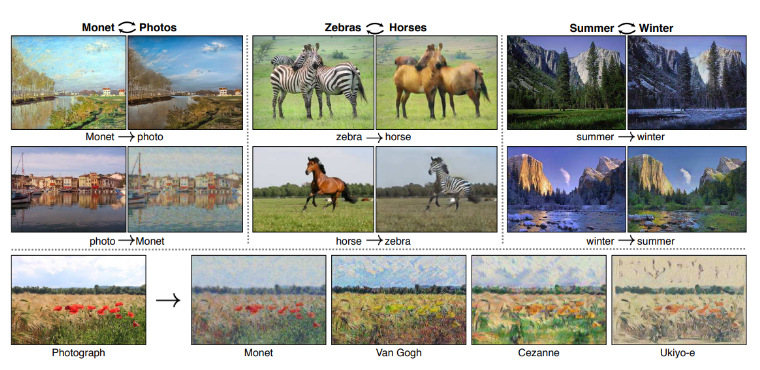

### also, i believe styleganv2 could prove more helpful since CycleGAN is  primarily being used to learn transformation between images of different styles which dosent make it able enough to produce high quality images. StyleGan on the other side is able to produce HD images and also offers control over the style of the generated image at different levels of detail through varying the style vectors and noise. Which may be useful for dashtoons creator dashboard